In [1]:
%load_ext autoreload
%autoreload 2

import sys; 
sys.path.insert(0, '../../esinet')
sys.path.insert(0, '../')

import numpy as np
from copy import deepcopy
from scipy.sparse.csgraph import laplacian
from matplotlib import pyplot as plt
from scipy.spatial.distance import cdist
from scipy.stats import pearsonr
import mne
from esinet import Simulation
from esinet.forward import get_info, create_forward_model
from esinet.util import unpack_fwd
from invert.cmaps import parula
pp = dict(surface='white', hemi='both')

In [47]:
info = get_info(kind='biosemi64')
fwd = create_forward_model(info=info, sampling='ico3')

leadfield, pos = unpack_fwd(fwd)[1:3]
n_chans, n_dipoles = leadfield.shape

source_model = fwd['src']
vertices = [source_model[0]['vertno'], source_model[1]['vertno']]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:    0.3s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.3s finished


Using control points [0.         0.00059511 0.02011662]
For automatic theme detection, "darkdetect" has to be installed! You can install it with `pip install darkdetect`
For automatic theme detection, "darkdetect" has to be installed! You can install it with `pip install darkdetect`
To use light mode, "qdarkstyle" has to be installed! You can install it with:
pip install qdarkstyle

For automatic theme detection, "darkdetect" has to be installed! You can install it with `pip install darkdetect`
For automatic theme detection, "darkdetect" has to be installed! You can install it with `pip install darkdetect`
To use light mode, "qdarkstyle" has to be installed! You can install it with:
pip install qdarkstyle

No projector specified for this dataset. Please consider the method self.add_proj.


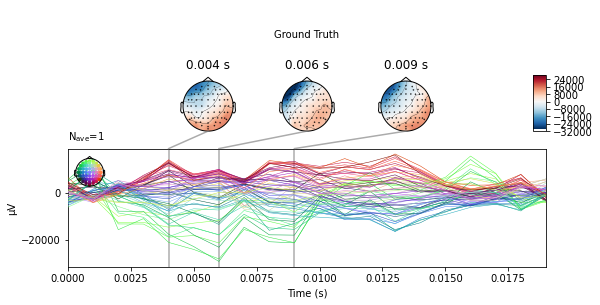

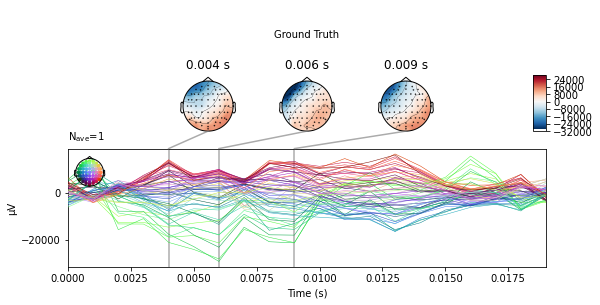

In [74]:
from invert.solvers.esinet import generator

sim_params = dict(
    use_cov=False, 
    return_mask=False, 
    batch_repetitions=1,
    batch_size=1,
    n_sources=5, 
    n_orders=(1, 3), 
    snr_range=(8, 9), 
    n_timecourses=2000,
    scale_data=False)
    
gen = generator(fwd, **sim_params)

x, y = gen.__next__()

tmin = 0
tstep = 1/info["sfreq"]
subject = "fsaverage"
evoked = mne.EvokedArray(x[0].T, info, tmin=tmin)
stc = mne.SourceEstimate(y[0].T, vertices, tmin=tmin, tstep=tstep, 
                        subject=subject, verbose=0)
                        
brain = stc.plot(**pp)
brain.add_text(0.1, 0.9, "Ground Truth", 'title',
               font_size=14)
evoked.plot_joint(title="Ground Truth")

# MM Bayes

In [16]:
from copy import deepcopy
F = deepcopy(leadfield)
F -= F.mean(axis=0)
F /= np.linalg.norm(F, axis=0)

Y = evoked.data
Y -= Y.mean(axis=0)
Y_scaled = Y / abs(Y).mean()

n_chans, n_dipoles = F.shape
T = Y.shape[1]

max_iter = 200
beta = 0.001
v = np.identity(n_dipoles)
I = np.identity(n_chans)
F_EM_list = []

for i in range(max_iter):
    sigma_y = beta * I + F @ v @ F.T
    sigma_y_inv = np.linalg.inv(sigma_y)

    
    X_bar = v @ F.T @ sigma_y_inv @ Y
    sigma_x = v - v @ F.T @ sigma_y_inv @ F @ v
    mu_x = v @ F.T @ sigma_y_inv @ Y

    for p in range(n_dipoles):
        v[p,p] = sigma_x[p,p] + (1/T) * (mu_x[p]**2).sum()
    
    
    v_inv = np.linalg.inv(v)
    F_EM = np.squeeze((1/T) * np.array([y[:, np.newaxis].T @ sigma_y_inv @ y[:, np.newaxis] for y in Y.T]).sum(axis=0)) + np.log(np.linalg.norm(sigma_y))
    F_EM_list.append(F_EM)
    print(F_EM)

Sigma_y = (beta**2) * I + F @ v @ F.T
Sigma_y_inv = np.linalg.inv(Sigma_y)
inverse_operator = v @ F.T @ Sigma_y_inv

X = inverse_operator @ Y

stc_ = stc.copy()
stc_.data = X
stc_.plot(**pp)

6.439055543930006
6.396504224689564
6.356289434922519
6.317662370889336
6.280226391944185
6.243735129433579
6.208020830947641
6.1729620528349045
6.138466965978467
6.104463865345443
6.070895363310162
6.0377146238964485
6.004882804964243
5.972367255811067
5.940140209191675
5.908177809190535
5.876459374233298
5.844966828851008
5.813684259089888
5.782597560150397
5.751694153921043
5.720962760246115
5.690393210046404
5.659976291427971
5.629703622070533
5.599567542749952
5.569561027997897
5.539677610757272
5.509911318538291
5.48025661907456
5.450708373862481
5.4212617982679925
5.391912427123878
5.362656084931708
5.333488859937206
5.304407081472934
5.275407300065072
5.246486269885084
5.217640933196729
5.188868406506371
5.160165968172299
5.131531047268622
5.102961213532361
5.074454168250096
5.046007735963616
5.01761985689341
4.989288579994824
4.9610120565753375
4.932788534412547
4.904616352321729
4.876493935129713
4.848419789018058
4.820392497203922
4.7924107159312435
4.764473170748496
4.73657

Using control points [0.00052624 0.00062339 0.00110925]
Using control points [0.00052624 0.00062339 0.00110925]


# MacKay Bayes

In [75]:
from copy import deepcopy
F = deepcopy(leadfield)
F -= F.mean(axis=0)
F /= np.linalg.norm(F, axis=0)
F /= abs(F).mean()

Y = evoked.data
Y -= Y.mean(axis=0)
Y_scaled = Y / abs(Y).mean()

n_chans, n_dipoles = F.shape
T = Y.shape[1]

prune = True
pruning_thresh=1e-3

max_iter = 200
beta = 0.00
v = np.ones(n_dipoles)
I = np.identity(n_chans)
F_MK_list = [1e99,]
v_list = [deepcopy(v),]

for i in range(max_iter):
    V = np.diag(v)
    sigma_y = beta * I + F @ V @ F.T
    sigma_y_inv = np.linalg.inv(sigma_y)
    
    X_bar = V @ F.T @ sigma_y_inv @ Y_scaled
    sigma_x = V - V @ F.T @ sigma_y_inv @ F @ V

    z = np.zeros(n_dipoles)
    for p in range(n_dipoles):
        f_p = F[:, p][:, np.newaxis]
        z[p] = v[p] * f_p.T @ sigma_y_inv @ f_p
        
        upper_term = (1/T) * (X_bar[p]**2).sum()
        v[p] = upper_term / z[p]

    if prune:
        prune_candidates = v<pruning_thresh
        v[prune_candidates] = 0
        v[np.isnan(v)] = 0
    
    if np.linalg.norm(v) == 0:
        # print("breaking")
        v = v_list[-1]
        break
    
    # F_MK = np.squeeze((1/T) * np.array([y[:, np.newaxis].T @ sigma_y_inv @ y[:, np.newaxis] for y in Y_scaled.T]).sum(axis=0)) + np.log(np.linalg.norm(sigma_y))
    # F_MK = np.squeeze((1/T) * (Y_scaled.T @ sigma_y_inv @ Y_scaled).sum() + np.log(np.linalg.norm(sigma_y)))
    F_MK = np.trace(F@V@F.T) + (1/T) * (Y_scaled.T@sigma_y_inv@Y_scaled).sum()
    # F_MK = (1/T) * (X_bar.T @ np.linalg.inv(V) @ X_bar).sum() + np.trace(np.diag(z).T@np.diag(np.log(v))) - np.conjugate(z).sum()

    F_MK_list.append(F_MK)
    print(F_MK)
    if F_MK_list[-1] > F_MK_list[-2]:
        print("break: ", np.nanmean(v), np.nanmean(v_list[-1]))
        v = v_list[-1]
        break
    v_list.append(v)
    
v[np.isnan(v)] = 0
v /= v.max()
V = np.diag(v)
Sigma_y = (beta**2) * I + F @ V @ F.T
Sigma_y_inv = np.linalg.inv(Sigma_y)
inverse_operator = V @ F.T @ Sigma_y_inv

X = inverse_operator @ Y

stc_ = stc.copy()
stc_.data = X
stc_.plot(**pp)

129370.31342150422


C:\Users\Lukas\AppData\Local\Temp\ipykernel_4756\3152690775.py:38: RuntimeWarning: invalid value encountered in double_scalars
  v[p] = upper_term / z[p]


388.5276921528331
280.64119971425225
262.98903072743167
256.9738389121678
251.05215256769836
251.81850990462982
break:  0.0014149135666964654 0.0014149135666964654
Using control points [0.00020429 0.00031353 0.00174061]
For automatic theme detection, "darkdetect" has to be installed! You can install it with `pip install darkdetect`
For automatic theme detection, "darkdetect" has to be installed! You can install it with `pip install darkdetect`
To use light mode, "qdarkstyle" has to be installed! You can install it with:
pip install qdarkstyle

For automatic theme detection, "darkdetect" has to be installed! You can install it with `pip install darkdetect`
For automatic theme detection, "darkdetect" has to be installed! You can install it with `pip install darkdetect`
To use light mode, "qdarkstyle" has to be installed! You can install it with:
pip install qdarkstyle



Using control points [0.00019741 0.00033666 0.00159458]
Using control points [0.         0.00028113 0.01392332]
Using control points [0.00024846 0.00035885 0.00253561]


# Convexity Bayes

In [14]:
from copy import deepcopy
F = deepcopy(leadfield)
F -= F.mean(axis=0)
F /= np.linalg.norm(F, axis=0)
F /= abs(F).mean()

Y = evoked.data
Y -= Y.mean(axis=0)
Y_scaled = Y / abs(Y).mean()

n_chans, n_dipoles = F.shape
T = Y.shape[1]

prune = True
pruning_thresh=0

max_iter = 25
beta = 1e-8
v = np.ones(n_dipoles)
I = np.identity(n_chans)
F_EM_list = [1e99,]
v_list = [deepcopy(v),]

for i in range(max_iter):
    V = np.diag(v)
    sigma_y = beta * I + F @ V @ F.T
    sigma_y_inv = np.linalg.inv(sigma_y)
    
    X_bar = V @ F.T @ sigma_y_inv @ Y_scaled
    sigma_x = V - V @ F.T @ sigma_y_inv @ F @ V
    # sigma_x = (1/beta) * F.T @ F + np.linalg.inv(V)

    for p in range(n_dipoles):
        f_p = F[:, p][:, np.newaxis]
        
        g = np.trace(f_p.T @ sigma_y_inv @ f_p)
        upper_term = (1/T) * (X_bar[p]**2).sum()
        v[p] = np.sqrt(upper_term / g)

    if prune:
        prune_candidates = v<pruning_thresh
        v[prune_candidates] = 0
        v[np.isnan(v)] = 0
    
    if np.linalg.norm(v) == 0:
        # print("breaking")
        v = v_list[-1]
        break
    
    F_EM = np.squeeze((1/T) * np.array([y[:, np.newaxis].T @ sigma_y_inv @ y[:, np.newaxis] for y in Y.T]).sum(axis=0)) + np.log(np.linalg.norm(sigma_y))
    F_EM_list.append(F_EM)
    print(F_EM)
    if F_EM_list[-1] > F_EM_list[-2]:
        print("break: ", np.nanmean(v), np.nanmean(v_list[-1]))
        v = v_list[-1]
        break
    v_list.append(v)
    
v[np.isnan(v)] = 0
v /= v.max()
V = np.diag(v)
Sigma_y = (beta**2) * I + F @ V @ F.T
Sigma_y_inv = np.linalg.inv(Sigma_y)
inverse_operator = V @ F.T @ Sigma_y_inv

X = inverse_operator @ Y

stc_ = stc.copy()
stc_.data = X
stc_.plot(**pp)

11.051676862204095
8.165516667326372
6.565679647860019
5.68221965779458
5.225748114012544
5.011614376842259
4.931879153285573
4.919235579908102
4.929893832455553
break:  0.0020487461725441436 0.0020487461725441436
Using control points [5.06493811e-05 7.83803144e-05 7.37022204e-04]
For automatic theme detection, "darkdetect" has to be installed! You can install it with `pip install darkdetect`
For automatic theme detection, "darkdetect" has to be installed! You can install it with `pip install darkdetect`
To use light mode, "qdarkstyle" has to be installed! You can install it with:
pip install qdarkstyle

For automatic theme detection, "darkdetect" has to be installed! You can install it with `pip install darkdetect`
For automatic theme detection, "darkdetect" has to be installed! You can install it with `pip install darkdetect`
To use light mode, "qdarkstyle" has to be installed! You can install it with:
pip install qdarkstyle



Using control points [5.06300133e-05 7.53476414e-05 4.88091665e-04]
Using control points [5.06300133e-05 7.53476414e-05 4.88091665e-04]
